# Sanity checking Public datasets

In [2]:
from pathlib import Path
from datetime import datetime as dt
from collections import Counter

import nibabel as nib
import nilearn.plotting as nilp
import numpy as np
import pandas as pd

import sage.xai.nilearn_plots as nilp_


DATA_HOME = Path("/home/data/hdd01/brain")
datasets = sorted([d for d in DATA_HOME.iterdir() if d.is_dir()])
datasets

[PosixPath('/home/data/hdd01/brain/AGE-ility'),
 PosixPath('/home/data/hdd01/brain/BraTS2020'),
 PosixPath('/home/data/hdd01/brain/BraTS2020_h5'),
 PosixPath('/home/data/hdd01/brain/ISLES2022'),
 PosixPath('/home/data/hdd01/brain/PKG - UPENN-GBM-NIfTI'),
 PosixPath('/home/data/hdd01/brain/PPMI'),
 PosixPath('/home/data/hdd01/brain/Pretreat-MetsToBrain-Masks'),
 PosixPath('/home/data/hdd01/brain/SHIFTS')]

### Tasks 
- Find a unique number of patients. 
- With a single sample:
    - Visualization
    - Compare with biobank samples:
        - Check affine and dimension
        - Range of values in array
- Check labels

## AGE-ility

- Contains T1, DWI(b1000, b3000), rs-fMRI, rs-EEG
- We will check T1 only, for easier translation of model trained on UKB.

1. Unique # patients

In [3]:
AGEILITY_MODALITY = {
    "A_P_mag_FIELDMAPPING",
    "A_P_phase_FIELDMAPPING",
    "P_A_mag_FIELDMAPPING",
    "P_A_phase_FIELDMAPPING",
    "RESTING_EEG",
    "T1",
    "b1000",
    "b1000_A_P",
    "b1000_P_A",
    "b3000",
    "b3000_A_P",
    "b3000_P_A",
    "rsfMRI",
}

ageility_files = sorted(filter(lambda f: f.is_dir(), datasets[0].iterdir()))
len(ageility_files)

132

In [4]:
def _load_ageility(ppath: Path, modality: str) -> Path:
    assert modality in AGEILITY_MODALITY, f"Ensure modality is one of AGE-ility modality: {modality}"
    _path = ppath / modality
    return _path


def load_t1_ageility(ppath: Path) -> nib.Nifti1Image:
    """Arguments
    ppath: Path of certain PID, e.g. ~/AGE-ility/001
    """
    _path = _load_ageility(ppath=ppath, modality="T1")
    t1 = sorted(_path.glob("*.nii"))[0]
    t1 = nib.load(t1)
    return t1


def fetch_metadata(nii: nib.Nifti1Image, count_nonzero: bool = False) -> dict:
    """Fetch meta data of nifti object and assort them into dict """
    shape = nii.shape
    affine = nii.affine
    arr = nii.get_fdata()
    max_, min_, mean_ = arr.max(), arr.min(), arr.mean()
    result = dict(shape=shape, affine=affine, max=max_, min=min_, mean=mean_)
    if count_nonzero:
        nonzero = np.count_nonzero(arr)
        result["nonzero"] = nonzero
    return result

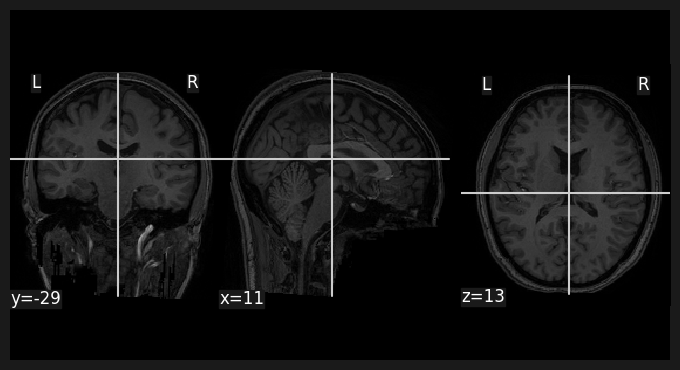

In [5]:
nii = load_t1_ageility(ppath=ageility_files[0])
nilp.plot_anat(nii)

In [6]:
ageility_meta = [fetch_metadata(load_t1_ageility(ppath=p)) for p in ageility_files]

In [7]:
ageility_df = pd.DataFrame(ageility_meta)

In [10]:
ageility_df

,shape,affine,max,min,mean
0,"(171, 188, 193)","[[0.9995707869529724, 0.021449169144034386, 0....",619.0,0.0,58.369758
1,"(175, 205, 173)","[[0.999587893486023, -0.020506221801042557, -0...",661.0,0.0,70.003101
2,"(166, 214, 187)","[[0.9962126612663269, 0.03195440396666527, 0.0...",683.0,0.0,74.349629
3,"(176, 205, 195)","[[0.9999467730522156, -0.009990418329834938, 0...",644.0,0.0,61.164789
4,"(176, 221, 167)","[[0.9997992515563965, -0.001238676137290895, 0...",614.0,0.0,64.153957
...,...,...,...,...,...
126,"(157, 210, 187)","[[0.999792218208313, 0.0039974600076675415, 0....",665.0,0.0,72.380570
127,"(168, 214, 186)","[[0.9999999403953552, 0.0, 0.0, -78.4205703735...",542.0,0.0,64.437445
128,"(155, 215, 182)","[[0.9983624219894409, -0.05357646569609642, 0....",534.0,0.0,63.799616
129,"(171, 226, 180)","[[0.9990086555480957, 0.012774411588907242, 0....",646.0,0.0,75.710247


In [46]:
ageility_df.to_csv("./ageility_meta_df.csv", index=False)

## BraTS2020

In [28]:
BRATS_MODALITY: set = {"flair", "seg", "t1", "t1ce", "t2"}

In [24]:
brats_dir = datasets[1]
brats_train = brats_dir / "BraTS2020_TrainingData" / "MICCAI_BraTS2020_TrainingData"
brats_valid = brats_dir / "BraTS2020_ValidationData" / "MICCAI_BraTS2020_ValidationData"

brats_trn_files = sorted(filter(lambda f: f.is_dir(), brats_train.iterdir()))
brats_val_files = sorted(filter(lambda f: f.is_dir(), brats_valid.iterdir()))
len(brats_trn_files), len(brats_val_files)

(369, 125)

In [45]:
# Label files
sorted(brats_train.glob("*.csv")), sorted(brats_valid.glob("*.csv"))

([PosixPath('/home/data/hdd01/brain/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/name_mapping.csv'),
  PosixPath('/home/data/hdd01/brain/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/survival_info.csv')],
 [PosixPath('/home/data/hdd01/brain/BraTS2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/name_mapping_validation_data.csv'),
  PosixPath('/home/data/hdd01/brain/BraTS2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/survival_evaluation.csv')])

Visualization

1. Is Segmentation map correctly overlaid
2. 

In [42]:
def fetch_file(ppath: Path, modality: str = "t1") -> nib.Nifti1Image:
    assert modality in BRATS_MODALITY, f"Please provide available modality for BraTS, given: {modality}"

    # Fetch file
    files = sorted(ppath.iterdir())
    _files = [f.stem.split("_")[-1] for f in files]
    index = _files.index(modality)
    file = files[index]

    nii = nib.load(file)
    return nii


def check_overlay(ppath: Path, modality: str = "t1", alpha: float = 0.7) -> None:
    assert modality in BRATS_MODALITY, f"Please provide available modality for BraTS, given: {modality}"
    assert modality != "seg", f"Modality to compare should not be segmentation mask."
    
    # Load images    
    target = fetch_file(ppath=ppath, modality=modality)
    seg_msk = fetch_file(ppath=ppath, modality="seg")

    # Display overlay
    nilp.plot_anat(anat_img=target, title=f"Orig {modality} image")
    dp = nilp.plot_anat(anat_img=target, title=f"Segmentation mask overlaid image")
    dp.add_overlay(seg_msk, alpha=alpha)

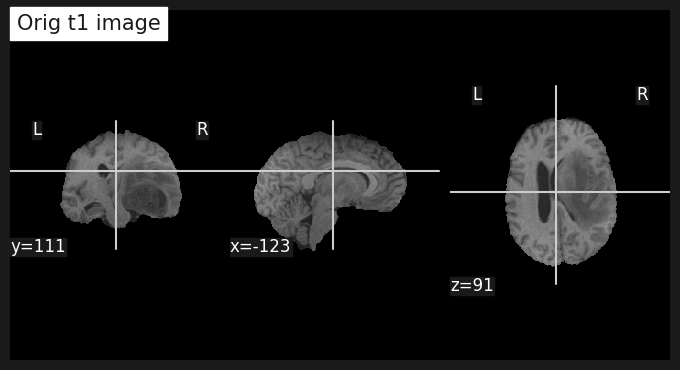

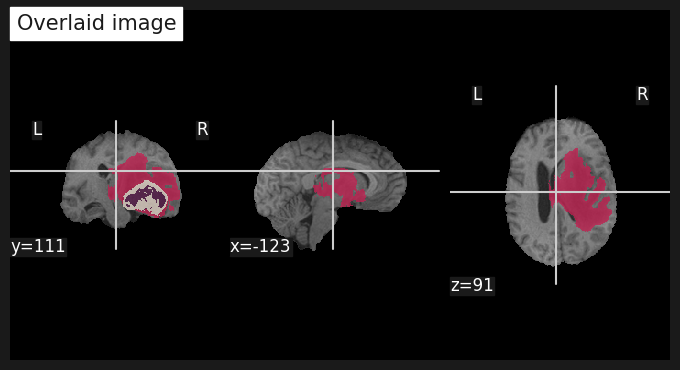

In [43]:
check_overlay(ppath=brats_trn_files[0])

In [44]:
brats_t1_trn_meta = [fetch_metadata(fetch_file(ppath=p, modality="t1")) for p in brats_trn_files]
brats_t1_val_meta = [fetch_metadata(fetch_file(ppath=p, modality="t1")) for p in brats_val_files]

In [48]:
pd.DataFrame(brats_t1_trn_meta).to_csv("./brats_t1_trn_meta.csv", index=False)
pd.DataFrame(brats_t1_val_meta).to_csv("./brats_t1_val_meta.csv", index=False)

## PPMI

Longitudinal Parkinson disease study

In [5]:
ppmi_dir = datasets[5]

ppmi_files = sorted(filter(lambda f: f.is_dir(), ppmi_dir.iterdir()))
len(ppmi_files)

356

In [6]:
PPMI_DT_FMT = "%Y-%m-%d_%H_%M_%S.%f"

In [7]:
PPMI_MODALITY = {"t1": "T1-anatomical", "t2": "T2_in_T1-anatomical_space"}
def fetch_ppmi_t1(ppath: Path, modality: str = "t1", date_index: int = 0) -> nib.Nifti1Image:
    """
    ppath: ~/PPMI/3101/
    date_index: Order of longitudinal PPMI to fetch
    """
    if modality not in PPMI_MODALITY:
        assert modality in PPMI_MODALITY.values(), f"Check if modality belongs to PPMI modality: {modality}"
    else:
        modality = PPMI_MODALITY[modality]
    path = ppath / modality
    files = sorted(filter(lambda f: f.is_dir(), path.iterdir()))
    file = files[date_index]
    # WE assume a single file in the single run
    file = sorted(file.rglob("*.nii"))[0]
    nii = nib.load(file)
    return nii

In [8]:
ppmi_niis = sorted(ppmi_dir.rglob("*.nii"))
len(ppmi_niis)

1674

In [9]:
# num T1
_num_t1_lst = [len(list((p / "T1-anatomical").iterdir())) for p in ppmi_files]
num_t1 = sum(_num_t1_lst)
_num_t2_lst = [len(list((p / "T2_in_T1-anatomical_space").iterdir())) for p in ppmi_files]
num_t2 = sum(_num_t2_lst)

print(f"# T1: {num_t1}\n# T2: {num_t2}")

# T1: 837
# T2: 837


In [10]:
Counter(_num_t1_lst), Counter(_num_t2_lst)

(Counter({2: 106, 1: 98, 3: 81, 4: 71}),
 Counter({2: 106, 1: 98, 3: 81, 4: 71}))

In [12]:
ppmi_niis[0]

PosixPath('/home/data/hdd01/brain/PPMI/14426/T1-anatomical/2014-02-26_10_55_06.0/I850059/PPMI_14426_MR_T1-anatomical_Br_20170510140445136_S214219_I850059.nii')

In [15]:
nii = fetch_ppmi_t1(ppath=ppmi_files[0])
print(nii.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='>'
sizeof_hdr      : 348
data_type       : b''
db_name         : b'14426'
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 176 240 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1. 1. 1. 1. 0. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'T1-anatomical'
aux_file        : b''
qform_code      : aligned
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : -0.0
qoffset_y       : -0.0
qoffset_z       : 0.0
srow_x          : [-1.  0.  0. -0.]


In [19]:
ppmi_demographics = pd.read_csv("brain/PPMI/ppmi_demographics.csv")
ppmi_demographics

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I994241,85242,Prodromal,M,66,V06,MRI,T2 in T1-anatomical space,Processed,2/08/2017,NiFTI,1/02/2024
1,I993557,85242,Prodromal,M,66,V06,MRI,T1-anatomical,Processed,2/08/2017,NiFTI,1/02/2024
2,I526619,85242,Prodromal,M,64,BL,MRI,T2 in T1-anatomical space,Processed,2/18/2015,NiFTI,1/02/2024
3,I696513,85242,Prodromal,M,65,V04,MRI,T2 in T1-anatomical space,Processed,2/03/2016,NiFTI,1/02/2024
4,I696817,85242,Prodromal,M,65,V04,MRI,T1-anatomical,Processed,2/03/2016,NiFTI,1/02/2024
...,...,...,...,...,...,...,...,...,...,...,...,...
1669,I476237,15761,Prodromal,F,70,BL,MRI,T2 in T1-anatomical space,Processed,9/30/2014,NiFTI,1/02/2024
1670,I848771,14426,Prodromal,M,61,BL,MRI,T2 in T1-anatomical space,Processed,2/26/2014,NiFTI,1/02/2024
1671,I785358,14426,Prodromal,M,63,V06,MRI,T1-anatomical,Processed,3/17/2016,NiFTI,1/02/2024
1672,I785201,14426,Prodromal,M,63,V06,MRI,T2 in T1-anatomical space,Processed,3/17/2016,NiFTI,1/02/2024


In [28]:
cond = (ppmi_demographics.Age <= 70) & (ppmi_demographics.Age >= 67) & (ppmi_demographics.Group == "Control")
cond.sum()

26

In [23]:
(ppmi_demographics.Age > 70).sum()

390

In [30]:
ppmi_demographics.Subject.nunique()

356

Group
PD           1086
Control       270
Prodromal     164
SWEDD         154
Name: count, dtype: int64

In [40]:
nodup = ppmi_demographics.drop_duplicates(subset="Subject")

In [42]:
nodup.Group.value_counts()

Group
PD           194
Control       75
Prodromal     46
SWEDD         41
Name: count, dtype: int64

Text(0.5, 1.0, 'PPMI Demographics')

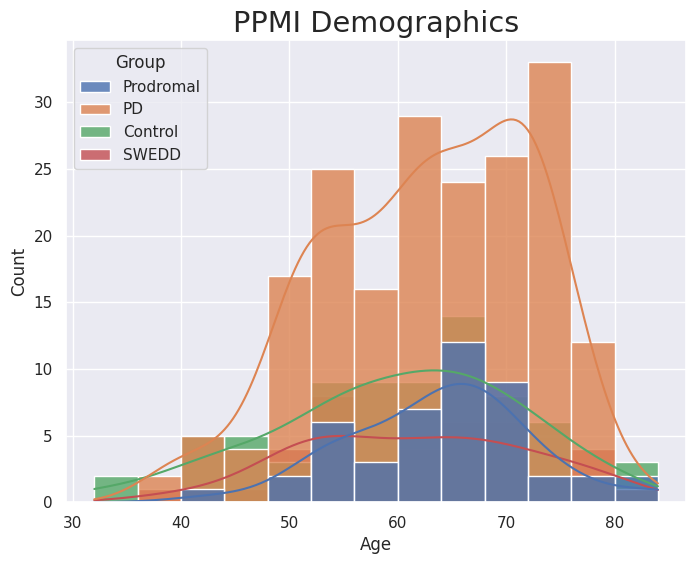

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(data=nodup, x="Age", hue="Group", alpha=0.8, kde=True, ax=ax)
ax.set_title("PPMI Demographics", size="xx-large")

<Axes: >

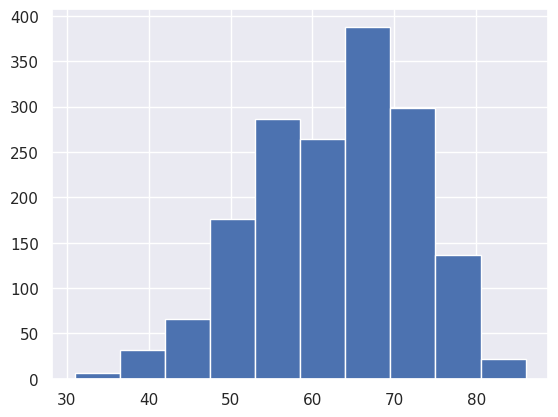

In [31]:
ppmi_demographics.Age.hist()

In [74]:
ppmi_t1_meta = [[fetch_metadata(nii=fetch_ppmi_t1(ppath=p, modality="t1", date_index=i))\
                for i in range(len(list((p / PPMI_MODALITY["t1"]).iterdir())))]
                for p in ppmi_files]
ppmi_t2_meta = [[fetch_metadata(nii=fetch_ppmi_t1(ppath=p, modality="t2", date_index=i))\
                for i in range(len(list((p / PPMI_MODALITY["t2"]).iterdir())))]
                for p in ppmi_files]


pd.DataFrame(ppmi_t1_meta).to_csv("./ppmi_t1_meta.csv", index=False)
pd.DataFrame(ppmi_t2_meta).to_csv("./ppmi_t2_meta.csv", index=False)

## ISLES2022

In [ ]:
isles_dir = datasets[1]
isles_files = sorted(isles_dir.iterdir())
_tmp = str(isles_dir)
!ls $_tmp

ISLES-2022  center_ids.xlsx


In [ ]:
labels = pd.read_excel(isles_files[1])
labels

,case,center
0,sub-strokecase0001,1
1,sub-strokecase0002,1
2,sub-strokecase0003,1
3,sub-strokecase0004,1
4,sub-strokecase0005,1
...,...,...
245,sub-strokecase0243,2
246,sub-strokecase0245,2
247,sub-strokecase0248,2
248,sub-strokecase0249,2


In [ ]:
labels.case.str[:-4].unique()

array(['sub-strokecase'], dtype=object)

Again, every case conatins stroke

In [ ]:
isles_scans = sorted(sorted([d for d in isles_files[0].iterdir() if d.is_dir() and d.name.startswith("sub-strokecase")]))
isles_masks = sorted([d for d in (isles_files[0] / "derivatives").iterdir() if d.is_dir() and d.name.startswith("sub-strokecase")])

len(isles_scans), len(isles_masks)

(250, 250)

In [ ]:
idx = 0
scan, mask = isles_scans[idx], isles_masks[idx]
scan, mask

(PosixPath('/home/data/hdd01/brain/ISLES2022/ISLES-2022/sub-strokecase0001'),
 PosixPath('/home/data/hdd01/brain/ISLES2022/ISLES-2022/derivatives/sub-strokecase0001'))

In [ ]:
import nibabel as nib


def open_scan(path: Path, ftype: str = "flair"):
    path = path / "ses-0001"
    if ftype == "flair":
        path = path / "anat"
        ftype = "FLAIR"
    elif ftype in {"adc", "dwi"}:
        path = path / "dwi"
    file = sorted(path.glob(f"*{ftype}.nii.gz"))
    if len(file) != 1:
        return
    nifti = nib.load(file[0])
    return nifti


def open_mask(path: Path):
    path = path / "ses-0001"
    file = sorted(path.glob("*msk.nii.gz"))
    if len(file) != 1:
        return
    nifti = nib.load(file[0])
    return nifti

In [ ]:
nii = open_scan(path=scan)
msk = open_mask(path=mask)

/home/1phantasmas/.conda/envs/age/lib/python3.10/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


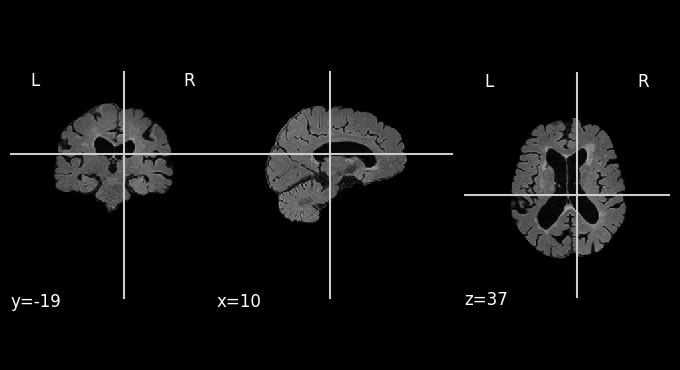

In [ ]:
import nilearn.plotting as nilp


dp = nilp.plot_anat(nii)
dp.add_overlay(msk)

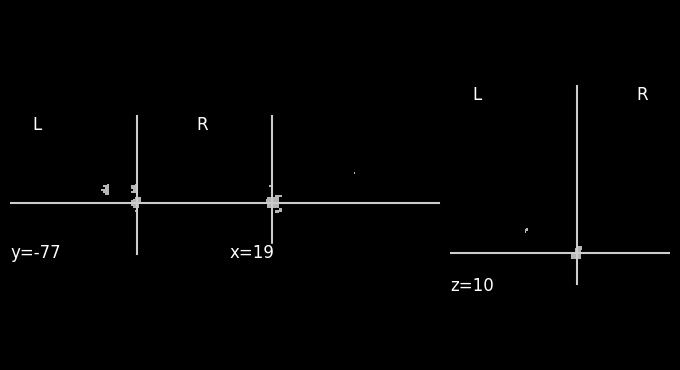

In [ ]:
nilp.plot_anat(msk)